In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from functools import partial
import requests
import os
import time
import geopandas as gpd

import datetime
import pytz

import seaborn as sns
import matplotlib.pyplot as plt

from math import sin, cos, sqrt, atan2, radians
from tqdm import tqdm

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split

from zipfile import ZipFile
from tzwhere import tzwhere

%matplotlib inline

In [2]:
# unzip fucntions

# def unzip_to_path(archive):
#     path_name = '-'.join(archive.split('.')[:-1])
#     zf = ZipFile(archive, 'r')
#     zf.extractall(path_name)
#     zf.close()
    
# for f in os.listdir('data'):
#     if f.find('.zip') != 1:
#         print('unzip file {}'.format(f))
#         unzip_to_path(os.path.join('data', f))

In [3]:
# filenames from osm archives
# poi gis_osm_pois_free_1.shp
# transport objects gis_osm_transport_free_1.shp
# traffic objects gis_osm_traffic_free_1.shp
# cities, towns, etc gis_osm_places_free_1.shp

In [6]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [7]:
def load_geo_dataframe(filename, path='data'):
    """ load geo dataframe with point geometries from files """
    
    df = None
    for f in tqdm(os.listdir(path)):
        if os.path.isdir(os.path.join(path,f)):
            if df is None:
                df = gpd.read_file(os.path.join(path, f, filename))
            else:
                df = df.append(gpd.read_file(os.path.join(path, f, filename)))

    df['lat'] = df.geometry.y
    df['long'] = df.geometry.x
    
    return df

In [8]:
R = 6373.0 # радиус земли в километрах

def distance(x,y):
    """
    Параметры
    ----------
    x : tuple, широта и долгота первой геокоординаты 
    y : tuple, широта и долгота второй геокоординаты 
    
    Результат
    ----------
    result : дистанция в километрах между двумя геокоординатами
    """
    lat_a, long_a, lat_b, long_b = map(radians, [*x,*y])    
    dlon = long_b - long_a
    dlat = lat_b - lat_a
    a = sin(dlat/2)**2 + cos(lat_a) * cos(lat_b) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

def nearest_distances(data, initial_data=None, metric=distance, n_neighbors=10):
    
    knc = KNeighborsClassifier(metric=metric)
    dots = data[['lat','long']].dropna()
    knc.fit(X=dots , y=np.ones(dots.shape[0]))
    if initial_data is None:
        distances, indexes = knc.kneighbors(X=dots, n_neighbors=n_neighbors)
    else:
        distances, indexes = knc.kneighbors(X=initial_data, n_neighbors=n_neighbors)
    
    return distances

def timezone_from_coordinates(lat, long, tzw):

    return tzw.tzNameAt(lat, long)

In [9]:
pois = load_geo_dataframe('gis_osm_pois_free_1.shp')
transport = load_geo_dataframe('gis_osm_transport_free_1.shp')
traffic = load_geo_dataframe('gis_osm_traffic_free_1.shp')
cities = load_geo_dataframe('gis_osm_places_free_1.shp')

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


In [10]:
points_categories = ['cafe', 'pharmacy', 'supermarket', 'atm', 'waste_basket', 'bank', 'clothes', 'doityourself',
                     'hairdresser', 'restaurant', 'fast_food', 'post_office', 'car_wash','hotel', 'florist',
                     'mobile_phone_shop', 'beauty_shop', 'dentist', 'school', 'bar', 'picnic_site', 'hospital', 
                     'doctors', 'furniture_shop', 'butcher', 'bakery', 'artwork', 'kiosk', 'post_box',
                     'shoe_shop', 'jeweller', 'museum', 'sports_centre']

transport_categories = ['railway_halt', 'railway_station', 'bus_station', 'ferry_terminal']

traffic_categories = ['fuel', 'parking', 'parking_underground', 'parking_bicycle', 'service', 'parking_multistorey']

In [11]:
banks = pois[pois.fclass=='bank']
atms = pois[pois.fclass=='atm']
points = pois[pois.fclass.isin(points_categories)]
transport = transport[transport.fclass.isin(['railway_halt', 'railway_station'])]
traffic = traffic[traffic.fclass.isin(traffic_categories)]

In [12]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)

In [13]:
coords = pd.read_csv('fixed_yandex_coordinates.csv')

In [14]:
# please, use YOUR Yandex API key
# usage examples for geocoder https://tech.yandex.ru/maps/doc/geocoder/desc/examples/geocoder_examples-docpage/
API_KEY = ''

In [15]:
train.address = [' '.join(adr.split()) for adr in train.address]
test.address = [' '.join(adr.split()) for adr in test.address]

coords.address = [' '.join(adr.split()) for adr in coords.address]

In [16]:
train_data = train.loc[train.lat.notnull(), :].append(train.loc[train.lat.isnull(), :][[
            'id', 'atm_group', 'address','target']].merge(coords, on='address', how='left'), sort=False).reset_index(drop=True)

test_data = test.loc[test.lat.notnull(), :].append(test.loc[test.lat.isnull(), :][[
            'id', 'atm_group', 'address']].merge(coords, on='address', how='left'), sort=False).reset_index(drop=True)

In [17]:
target = train_data['target']
train_data = train_data.drop('target', axis=1)

In [18]:
# YANDEX GEOCODING

# x - dataframe from file with hand fixed nan's in address_rus
# x = missed[['address', 'fixed_address']]

# adresses = []
# coords = []

# for adr in x.fixed_address.values:
#     api_adr = ' '.join(adr.split()).replace(' ', '+')
#     r = requests.get('https://geocode-maps.yandex.ru/1.x/?apikey={}&format=json&geocode={}'.format(
#                         API_KEY, api_adr))
#     j = r.json()
#     try:
#         adresses.append(j['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['metaDataProperty'][
#         'GeocoderMetaData']['Address'])
#     except:
#         adresses.append('NO ADRESS')
        
#     try:
#         coords.append(r.json()['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point'
#                               ]['pos'].split(' '))
#     except:
#         coords.append(['0','0'])

# formatted_addresses = []
# lat = []
# lon = []
# locality = []

# for n in range(len(adresses)):
#     if adresses[n] == 'NO ADRESS':
#         lat.append(0)
#         lon.append(0)
#         formatted_addresses.append(',,')
#         locality.append(',,')
#     else:
#         lat.append(float(coords[n][1]))
#         lon.append(float(coords[n][0]))
#         loc = ',,'
#         try:
#             for i in adresses[n]['Components']:
#                 if i['kind'] == 'locality':
#                      loc = ',,' + i['name']
#             locality.append(loc)
#         except:
#             locality.apppend(loc)
#         try:
#             addr_form = adresses[n]['formatted'].split(', ')
#             if len(addr_form)==1:
#                 new_addr = ', '.join(['', ''] + addr_form)
#             elif len(addr_form)==2:
#                 new_addr = ', '.join([''] + [addr_form[1]] + [addr_form[0]])
#             else:
#                 new_addr = ', '.join(addr_form[1:] + [addr_form[0]])
#             formatted_addresses.append(new_addr)
#         except:
#             formatted_addresses.append('')
            
# coordinates = pd.DataFrame([x.address.values, lat, lon, locality]).T
# coordinates.columns = ['address', 'lat', 'long', 'address_rus']
# coordinates.to_csv('fixed_yandex_coordinates.csv', index=False)

In [19]:
X = train_data.append(test_data).reset_index(drop=True)

In [20]:
tzw = tzwhere.tzwhere()
timezones = []

for i in tqdm(X[['lat', 'long']].values):
    try:
        timezones.append(timezone_from_coordinates(i[0], i[1], tzw))
    except:
        timezones.append('No_Zone')

        # add timezones        
X['timezones'] = timezones

100%|███████████████████████████████████████████████████████████████████████████| 8765/8765 [00:00<00:00, 18346.14it/s]


In [22]:
distances = nearest_distances(data=X, n_neighbors=6)
distances_osm = nearest_distances(data=points, initial_data=X[['lat','long']].dropna(), n_neighbors=10)
distances_transport = nearest_distances(data=transport, initial_data=X[['lat','long']].dropna(), n_neighbors=10)
distances_traffic = nearest_distances(data=traffic, initial_data=X[['lat','long']].dropna(), n_neighbors=10)
distances_cities = nearest_distances(data=cities, initial_data=X[['lat','long']].dropna(), n_neighbors=10)
distances_bank = nearest_distances(data=banks, initial_data=X[['lat','long']].dropna(), n_neighbors=10)
distances_atm = nearest_distances(data=atms, initial_data=X[['lat','long']].dropna(), n_neighbors=10)

In [23]:
distances_group = []
for gr in tqdm(X.atm_group.unique()):
    distances_group.append(nearest_distances(data=X[X.atm_group==gr], initial_data=X[['lat','long']].dropna(), n_neighbors=6))

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:36<00:00, 16.34s/it]


In [24]:
def add_distance_features(df, distances, feature_prefix):
    df_copy = df.copy()
    
    for n in range(distances.shape[1]):
        df_copy['{}_{}'.format(feature_prefix, n)] = distances[:, n]
        
    return df_copy

def add_stat_distance_features(df, feature_prefix):
    df_copy = df.copy()
    
    df_copy['{}_mean'.format(feature_prefix)] = df_copy.iloc[:, df_copy.columns.str.contains(feature_prefix)].mean(axis=1)
    df_copy['{}_median'.format(feature_prefix)] = df_copy.iloc[:, df_copy.columns.str.contains(feature_prefix)].median(axis=1)
    df_copy['{}_std'.format(feature_prefix)] = df_copy.iloc[:, df_copy.columns.str.contains(feature_prefix)].std(axis=1)
    df_copy['{}_interquartile'.format(feature_prefix)] = df_copy.iloc[:, df_copy.columns.str.contains(feature_prefix)].quantile(0.75, axis=1) - \
                               df_copy.iloc[:, df_copy.columns.str.contains(feature_prefix)].quantile(0.25, axis=1)
        
    df_copy['{}_min_max'.format(feature_prefix)] = df_copy.iloc[:, df_copy.columns.str.contains(feature_prefix)].max(axis=1) - \
                         df_copy.iloc[:, df_copy.columns.str.contains(feature_prefix)].min(axis=1)
        
    return df_copy

In [25]:
X_feat = add_distance_features(X[['lat','long']].dropna(), distances, 'distance_data')
X_feat = add_distance_features(X_feat, distances_osm, 'distance_osm')
X_feat = add_distance_features(X_feat, distances_transport, 'distance_transport')
X_feat = add_distance_features(X_feat, distances_cities, 'distance_cities')
X_feat = add_distance_features(X_feat, distances_traffic, 'distance_traffic')
X_feat = add_distance_features(X_feat, distances_bank, 'distance_bank')
X_feat = add_distance_features(X_feat, distances_atm, 'distance_atm')

for pref in ['distance_data','distance_osm','distance_transport','distance_cities','distance_traffic','distance_bank','distance_atm']:
    X_feat = add_stat_distance_features(X_feat, pref)

In [26]:
for n, gr in enumerate(X.atm_group.unique()):
    X_feat = add_distance_features(X_feat, distances_group[n], 'distance_group_{}'.format(gr))
    X_feat =add_stat_distance_features(X_feat, 'distance_group_{}'.format(gr))

In [27]:
X = X.merge(X_feat.drop_duplicates(subset=['lat','long']), on=['lat','long'], sort=False, how='left')

In [28]:
X['city'] = X[~X.address_rus.isnull()].address_rus.apply(lambda x: x.split(',')[2]) 

In [29]:
rare_cities = X.city.value_counts()[(X.city.value_counts() < 10) == True].index

In [30]:
X.city = X.city.apply(lambda x: 'RARE' if x in rare_cities else x)

In [31]:
X.city = X.city.rank().fillna(-1)
X.timezones = X.timezones.rank().fillna(-1)

In [57]:
# 'timezones',
X_ = X[:len(train_data)][['id', 'atm_group','lat', 'long',
       'distance_data_0', 'distance_data_1', 'distance_data_2',
       'distance_data_3', 'distance_data_4', 'distance_data_5',
       'distance_osm_0', 'distance_osm_1', 'distance_osm_2', 'distance_osm_3',
       'distance_osm_4', 'distance_osm_5', 'distance_osm_6', 'distance_osm_7',
       'distance_osm_8', 'distance_osm_9', 'distance_transport_0',
       'distance_transport_1', 'distance_transport_2', 'distance_transport_3',
       'distance_transport_4', 'distance_transport_5', 'distance_transport_6',
       'distance_transport_7', 'distance_transport_8', 'distance_transport_9',
       'distance_cities_0', 'distance_cities_1', 'distance_cities_2',
       'distance_cities_3', 'distance_cities_4', 'distance_cities_5',
       'distance_cities_6', 'distance_cities_7', 'distance_cities_8',
       'distance_cities_9', 'distance_traffic_0', 'distance_traffic_1',
       'distance_traffic_2', 'distance_traffic_3', 'distance_traffic_4',
       'distance_traffic_5', 'distance_traffic_6', 'distance_traffic_7',
       'distance_traffic_8', 'distance_traffic_9', 
        'distance_bank_0', 'distance_bank_1', 'distance_bank_2',
       'distance_bank_3', 'distance_bank_4', 'distance_bank_5',
       'distance_bank_6', 'distance_bank_7', 'distance_bank_8',
       'distance_bank_9', 'distance_atm_0', 'distance_atm_1', 'distance_atm_2',
       'distance_atm_3', 'distance_atm_4', 'distance_atm_5', 'distance_atm_6',
       'distance_atm_7', 'distance_atm_8', 'distance_atm_9',
        'distance_data_mean',
       'distance_data_median', 'distance_data_std',
       'distance_data_interquartile', 'distance_data_min_max',
       'distance_osm_mean', 'distance_osm_median', 'distance_osm_std',
       'distance_osm_interquartile', 'distance_osm_min_max',
       'distance_transport_mean', 'distance_transport_median',
       'distance_transport_std', 'distance_transport_interquartile',
       'distance_transport_min_max', 'distance_cities_mean',
       'distance_cities_median', 'distance_cities_std',
       'distance_cities_interquartile', 'distance_cities_min_max',
       'distance_traffic_mean', 'distance_traffic_median',
       'distance_traffic_std', 'distance_traffic_interquartile',
       'distance_traffic_min_max',
        'distance_bank_median', 'distance_bank_std',
       'distance_bank_interquartile', 'distance_bank_min_max',
       'distance_atm_mean', 'distance_atm_median', 'distance_atm_std',
       'distance_atm_interquartile', 'distance_atm_min_max',
       'distance_group_32.0_0', 'distance_group_32.0_1',
       'distance_group_32.0_2', 'distance_group_32.0_3',
       'distance_group_32.0_4', 'distance_group_32.0_5',
       'distance_group_32.0_mean', 'distance_group_32.0_median',
       'distance_group_32.0_std', 'distance_group_32.0_interquartile',
       'distance_group_32.0_min_max', 'distance_group_496.5_0',
       'distance_group_496.5_1', 'distance_group_496.5_2',
       'distance_group_496.5_3', 'distance_group_496.5_4',
       'distance_group_496.5_5', 'distance_group_496.5_mean',
       'distance_group_496.5_median', 'distance_group_496.5_std',
       'distance_group_496.5_interquartile', 'distance_group_496.5_min_max',
       'distance_group_1022.0_0', 'distance_group_1022.0_1',
       'distance_group_1022.0_2', 'distance_group_1022.0_3',
       'distance_group_1022.0_4', 'distance_group_1022.0_5',
       'distance_group_1022.0_mean', 'distance_group_1022.0_median',
       'distance_group_1022.0_std', 'distance_group_1022.0_interquartile',
       'distance_group_1022.0_min_max', 'distance_group_1942.0_0',
       'distance_group_1942.0_1', 'distance_group_1942.0_2',
       'distance_group_1942.0_3', 'distance_group_1942.0_4',
       'distance_group_1942.0_5', 'distance_group_1942.0_mean',
       'distance_group_1942.0_median', 'distance_group_1942.0_std',
       'distance_group_1942.0_interquartile', 'distance_group_1942.0_min_max',
       'distance_group_3185.5_0', 'distance_group_3185.5_1',
       'distance_group_3185.5_2', 'distance_group_3185.5_3',
       'distance_group_3185.5_4', 'distance_group_3185.5_5',
       'distance_group_3185.5_mean', 'distance_group_3185.5_median',
       'distance_group_3185.5_std', 'distance_group_3185.5_interquartile',
       'distance_group_3185.5_min_max', 'distance_group_5478.0_0',
       'distance_group_5478.0_1', 'distance_group_5478.0_2',
       'distance_group_5478.0_3', 'distance_group_5478.0_4',
       'distance_group_5478.0_5', 'distance_group_5478.0_mean',
       'distance_group_5478.0_median', 'distance_group_5478.0_std',
       'distance_group_5478.0_interquartile', 'distance_group_5478.0_min_max',
       'distance_group_8083.0_0', 'distance_group_8083.0_1',
       'distance_group_8083.0_2', 'distance_group_8083.0_3',
       'distance_group_8083.0_4', 'distance_group_8083.0_5',
       'distance_group_8083.0_mean', 'distance_group_8083.0_median',
       'distance_group_8083.0_std', 'distance_group_8083.0_interquartile',
       'distance_group_8083.0_min_max']]

Y_ = target

In [139]:
def hyperopt_xgb(X, y, N):
    """hyperparameters optimization with hyperopt"""

    print('hyperopt..')

    start_time = time.time()
    
    # search space to pass to hyperopt
    fspace = {'learning_rate':hp.choice('learning_rate', [0.03,0.05,0.07,0.1,0.2]), 
                'n_estimators': hp.choice('n_estimators', [100,200,300,400,500,600,700,800,900,1000]),
                'eta': hp.quniform('eta', 0.025, 0.25, 0.025),
                'max_depth':  hp.choice('max_depth', np.arange(5, 14, dtype=int)),
                'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
                'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
                'gamma': hp.quniform('gamma', 0, 1, 0.05),
                'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
                'alpha' :  hp.quniform('alpha', 0, 10, 1),
                'lambda': hp.quniform('lambda', 0, 2, 0.1)}
        
    # objective function to pass to hyperopt
    def objective(params):

        iteration_start = time.time()

        params.update({'random_state': 1, 'n_jobs':-1})
        
        losses = []
        print(params)
        model = xgb.XGBRegressor(**params)
        
        kf = KFold(n_splits=5, random_state=1, shuffle=True)
        
        for train_index, test_index in kf.split(X_):

            X_train, X_valid = X_.loc[train_index, :], X_.loc[test_index, :]
            Y_train, Y_valid = Y_[train_index], Y_[test_index]
            model.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], early_stopping_rounds=20, eval_metric='rmse',
                                            verbose=False)

            pred = model.predict(X_valid)
            losses.append(rmse(Y_valid, pred))

        iteration_time = time.time()-iteration_start
        loss = np.mean(losses)
        print('iteration time %.1f, loss %.5f' % (iteration_time, loss))

        return {'loss': loss, 'status': STATUS_OK,
                'runtime': iteration_time,
                'params': params}

    # object with history of iterations to pass to hyperopt
    trials = Trials()

    # loop over iterations of hyperopt
    for t in range(N):
        # run hyperopt, n_startup_jobs - number of first iterations with random search
        best = fmin(fn=objective, space=fspace, algo=partial(tpe.suggest, n_startup_jobs=10),
                    max_evals=50, trials=trials)

    print('best parameters', trials.best_trial['result']['params'])

    return trials.best_trial['result']['params']

In [140]:
# params = hyperopt_xgb(X_, Y_, N=50)

In [141]:
# Some of best parameters (from hypeopt)

# 0.4278
# {'alpha': 8.0, 'colsample_bytree': 0.8, 'eta': 0.17500000000000002, 'gamma': 0.0, 'lambda': 0.30000000000000004, 'learning_rate': 0.03, 'max_depth': 13, 'min_child_weight': 9.0, 'n_estimators': 300, 'subsample': 0.8, 'random_state': 1, 'n_jobs': -1}

# 0.04276
# {'alpha': 10.0, 'colsample_bytree': 1.0, 'eta': 0.2, 'gamma': 0.0, 'lambda': 0.9, 'learning_rate': 0.03, 'max_depth': 11, 'min_child_weight': 10.0, 'n_estimators': 400, 'subsample': 0.8, 'random_state': 1, 'n_jobs': -1}

# 0.04272
# {'alpha': 9.0, 'colsample_bytree': 0.9500000000000001, 'eta': 0.1, 'gamma': 0.0, 'lambda': 0.4, 'learning_rate': 0.03, 'max_depth': 9, 'min_child_weight': 8.0, 'n_estimators': 500, 'subsample': 0.7000000000000001, 'random_state': 1, 'n_jobs': -1}

In [143]:
kf = KFold(n_splits=10, random_state=1, shuffle=True)
results = []
models = []
n = 0

for train_index, test_index in kf.split(X_):
    
    print("{} Fold".format(n))
    
    X_train, X_valid = X_.loc[train_index, :], X_.loc[test_index, :]
    Y_train, Y_valid = Y_[train_index], Y_[test_index]

    gbm = xgb.XGBRegressor(**{'alpha': 10.0, 'colsample_bytree': 1.0, 'eta': 0.2, 'gamma': 0.0, 'lambda': 0.9, 'learning_rate': 0.03, 'max_depth': 11, 'min_child_weight': 10.0, 'n_estimators': 400, 'subsample': 0.8, 'random_state': 1, 'n_jobs': -1})

    gbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], early_stopping_rounds=20, eval_metric='rmse',
            verbose=False)
    
    models.append(gbm)
    results.append(rmse(Y_valid, gbm.predict(X_valid)))

    n += 1
    
print("results: {}, mean_result: {:.5f}, std: {:.4f}".format(results, np.mean(results), np.std(results)))

0 Fold
1 Fold
2 Fold
3 Fold
4 Fold
5 Fold
6 Fold
7 Fold
8 Fold
9 Fold
results: [0.0419288808336086, 0.04256042197843748, 0.04145025140857796, 0.041428477106850235, 0.040819207804213234, 0.04296864185617612, 0.04340602369871922, 0.04215785169282351, 0.042567132815995445, 0.042447846032292874], mean_result: 0.04217, std: 0.0007


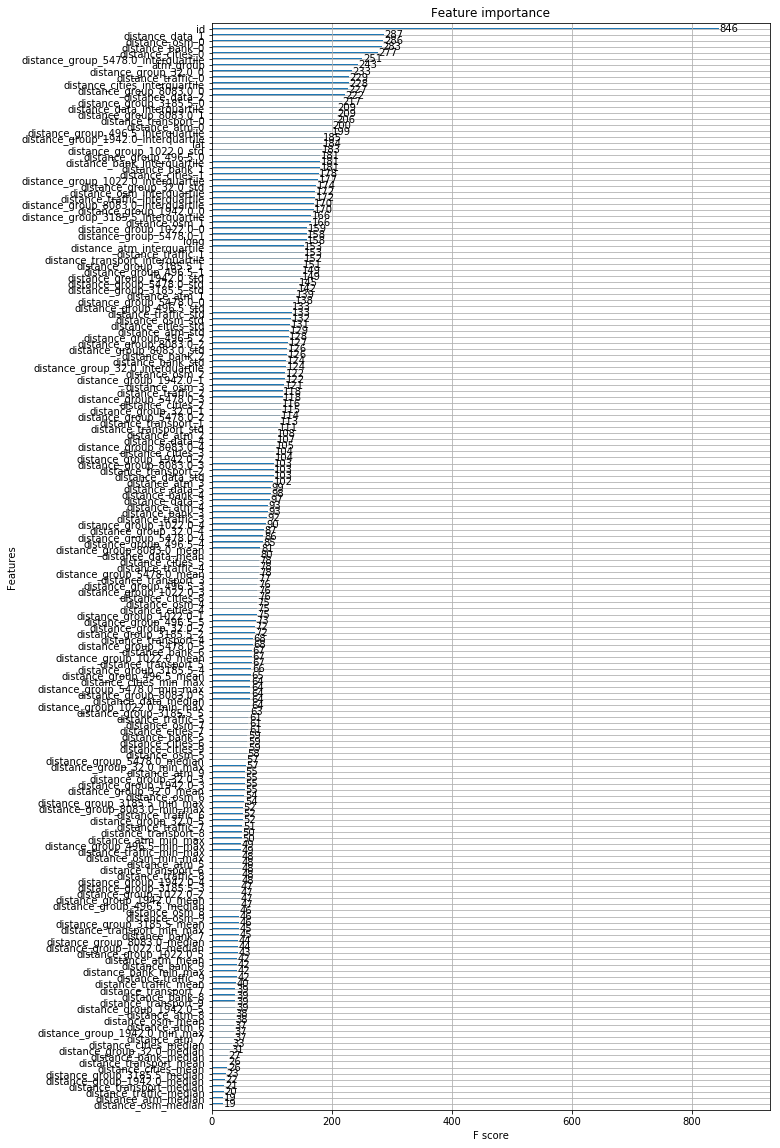

In [144]:
fig, ax = plt.subplots(figsize=(10,20))
xgb.plot_importance(gbm, ax=ax)

In [146]:
X_test = X[len(train_data):].sort_values(by='id')[['id', 'atm_group','lat', 'long',
       'distance_data_0', 'distance_data_1', 'distance_data_2',
       'distance_data_3', 'distance_data_4', 'distance_data_5',
       'distance_osm_0', 'distance_osm_1', 'distance_osm_2', 'distance_osm_3',
       'distance_osm_4', 'distance_osm_5', 'distance_osm_6', 'distance_osm_7',
       'distance_osm_8', 'distance_osm_9', 'distance_transport_0',
       'distance_transport_1', 'distance_transport_2', 'distance_transport_3',
       'distance_transport_4', 'distance_transport_5', 'distance_transport_6',
       'distance_transport_7', 'distance_transport_8', 'distance_transport_9',
       'distance_cities_0', 'distance_cities_1', 'distance_cities_2',
       'distance_cities_3', 'distance_cities_4', 'distance_cities_5',
       'distance_cities_6', 'distance_cities_7', 'distance_cities_8',
       'distance_cities_9', 'distance_traffic_0', 'distance_traffic_1',
       'distance_traffic_2', 'distance_traffic_3', 'distance_traffic_4',
       'distance_traffic_5', 'distance_traffic_6', 'distance_traffic_7',
       'distance_traffic_8', 'distance_traffic_9', 
        'distance_bank_0', 'distance_bank_1', 'distance_bank_2',
       'distance_bank_3', 'distance_bank_4', 'distance_bank_5',
       'distance_bank_6', 'distance_bank_7', 'distance_bank_8',
       'distance_bank_9', 'distance_atm_0', 'distance_atm_1', 'distance_atm_2',
       'distance_atm_3', 'distance_atm_4', 'distance_atm_5', 'distance_atm_6',
       'distance_atm_7', 'distance_atm_8', 'distance_atm_9',
        'distance_data_mean',
       'distance_data_median', 'distance_data_std',
       'distance_data_interquartile', 'distance_data_min_max',
       'distance_osm_mean', 'distance_osm_median', 'distance_osm_std',
       'distance_osm_interquartile', 'distance_osm_min_max',
       'distance_transport_mean', 'distance_transport_median',
       'distance_transport_std', 'distance_transport_interquartile',
       'distance_transport_min_max', 'distance_cities_mean',
       'distance_cities_median', 'distance_cities_std',
       'distance_cities_interquartile', 'distance_cities_min_max',
       'distance_traffic_mean', 'distance_traffic_median',
       'distance_traffic_std', 'distance_traffic_interquartile',
       'distance_traffic_min_max',
        'distance_bank_median', 'distance_bank_std',
       'distance_bank_interquartile', 'distance_bank_min_max',
       'distance_atm_mean', 'distance_atm_median', 'distance_atm_std',
       'distance_atm_interquartile', 'distance_atm_min_max',
       'distance_group_32.0_0', 'distance_group_32.0_1',
       'distance_group_32.0_2', 'distance_group_32.0_3',
       'distance_group_32.0_4', 'distance_group_32.0_5',
       'distance_group_32.0_mean', 'distance_group_32.0_median',
       'distance_group_32.0_std', 'distance_group_32.0_interquartile',
       'distance_group_32.0_min_max', 'distance_group_496.5_0',
       'distance_group_496.5_1', 'distance_group_496.5_2',
       'distance_group_496.5_3', 'distance_group_496.5_4',
       'distance_group_496.5_5', 'distance_group_496.5_mean',
       'distance_group_496.5_median', 'distance_group_496.5_std',
       'distance_group_496.5_interquartile', 'distance_group_496.5_min_max',
       'distance_group_1022.0_0', 'distance_group_1022.0_1',
       'distance_group_1022.0_2', 'distance_group_1022.0_3',
       'distance_group_1022.0_4', 'distance_group_1022.0_5',
       'distance_group_1022.0_mean', 'distance_group_1022.0_median',
       'distance_group_1022.0_std', 'distance_group_1022.0_interquartile',
       'distance_group_1022.0_min_max', 'distance_group_1942.0_0',
       'distance_group_1942.0_1', 'distance_group_1942.0_2',
       'distance_group_1942.0_3', 'distance_group_1942.0_4',
       'distance_group_1942.0_5', 'distance_group_1942.0_mean',
       'distance_group_1942.0_median', 'distance_group_1942.0_std',
       'distance_group_1942.0_interquartile', 'distance_group_1942.0_min_max',
       'distance_group_3185.5_0', 'distance_group_3185.5_1',
       'distance_group_3185.5_2', 'distance_group_3185.5_3',
       'distance_group_3185.5_4', 'distance_group_3185.5_5',
       'distance_group_3185.5_mean', 'distance_group_3185.5_median',
       'distance_group_3185.5_std', 'distance_group_3185.5_interquartile',
       'distance_group_3185.5_min_max', 'distance_group_5478.0_0',
       'distance_group_5478.0_1', 'distance_group_5478.0_2',
       'distance_group_5478.0_3', 'distance_group_5478.0_4',
       'distance_group_5478.0_5', 'distance_group_5478.0_mean',
       'distance_group_5478.0_median', 'distance_group_5478.0_std',
       'distance_group_5478.0_interquartile', 'distance_group_5478.0_min_max',
       'distance_group_8083.0_0', 'distance_group_8083.0_1',
       'distance_group_8083.0_2', 'distance_group_8083.0_3',
       'distance_group_8083.0_4', 'distance_group_8083.0_5',
       'distance_group_8083.0_mean', 'distance_group_8083.0_median',
       'distance_group_8083.0_std', 'distance_group_8083.0_interquartile',
       'distance_group_8083.0_min_max']]

In [147]:
submit = pd.DataFrame(np.mean([gbm.predict(X_test) for gbm in models], axis=0), index=test.sort_values(by='id').index, 
                      columns=['target'])

In [148]:
submit.sort_index().to_csv('submit_not_fixed.csv')

In [149]:
# we have a little leak - mean of train target and predicted target is 0
# and std of train targets and predicted targets must be 0.1 (because we divide by 10 our target)
submit.target.mean(), np.mean(target), np.std(list(submit.target * 10) + list(target * 10))

(-0.00037068984, 0.0007147964950465309, 0.8227836143114499)

In [151]:
# let substract bias in train data
submit.target = submit.target - (np.mean(target) + submit.target.mean())

In [152]:
submit.sort_index().to_csv('submit_fixed.csv')